Copyright (c) MONAI Consortium  
Licensed under the Apache License, Version 2.0 (the "License");  
you may not use this file except in compliance with the License.  
You may obtain a copy of the License at  
&nbsp;&nbsp;&nbsp;&nbsp;http://www.apache.org/licenses/LICENSE-2.0  
Unless required by applicable law or agreed to in writing, software  
distributed under the License is distributed on an "AS IS" BASIS,  
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.  
See the License for the specific language governing permissions and  
limitations under the License.

# Synthetic images generation and training tutorial with Medigan library

In this tutorial, we will introduce the use of synthetic data generation for training a classification model using pretrained models from Medigan library.

We'll go through the following steps:
* Choose the right model for the use-case
* Generate synthetic dataset
* Use MONAI transforms to pre-process data
* Use the DenseNet from MONAI for classification training
* Train the model on synthetic data with PyTorch
* Evaluate on real test dataset

### Import necessary libraries including MediganDataset

In [1]:
import os
import monai
from monai.apps.datasets import MediganDataset
from monai.data import DataLoader, CacheDataset
import torch
from torchmetrics.classification import BinaryAccuracy
import matplotlib.pyplot as plt
import numpy as np
from monai.transforms import (
    Compose,
    EnsureChannelFirstd,
    LoadImaged,
    MaskIntensityd,
    RandFlipd,
    RandRotated,
    RandZoomd,
    ResizeWithPadOrCropd,
    ScaleIntensityd,
    ToTensord,
)


### Create MediganDataset and generate synthetic data

In this tutorial, we will use conditional DCGAN model trained on Breast Imaging data.


Full list of avaialble models is avaialble at: https://github.com/RichardObi/medigan#available-models

In [31]:
model_id = '00008_C-DCGAN_MMG_MASSES'

temp_data_directory = "temp_dir"

train_synth_dataset = MediganDataset(temp_data_directory, model_id, 3000)
val_synth_dataset = MediganDataset(temp_data_directory, model_id, 1000)

100%|██████████| 188/188 [00:47<00:00,  3.97it/s]
/home/grzegorz-skorupko/projects/MONAI/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.io.dictionary LoadImaged.__init__:image_only: Current default value of argument `image_only=False` has been deprecated since version 1.1. It will be changed to `image_only=True` in version 1.3.
  warn_deprecated(argname, msg, warning_category)
Loading dataset: 100%|██████████| 1000/1000 [00:00<00:00, 1804.26it/s]


### Visualise some generated images

In this case, model generates grayscale images with size 128x128. It allows to create 'benign' and 'malignant' samples of images.

Generated image size: torch.Size([128, 128])


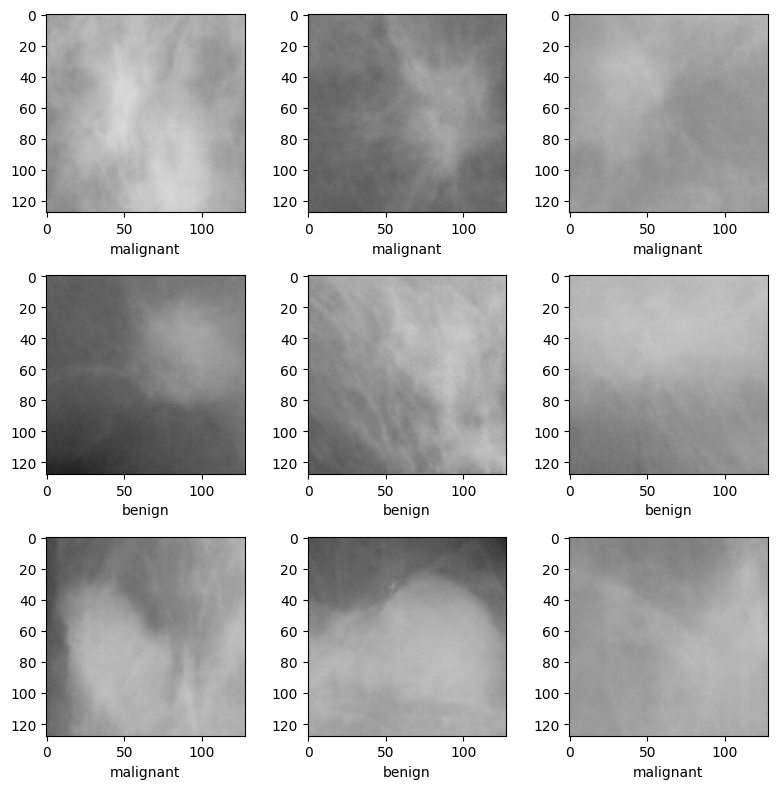

In [32]:
sample_image = train_synth_dataset[0]["image"]

print(f"Generated image size: {sample_image.shape}")

num_total = len(train_synth_dataset)
plt.subplots(3, 3, figsize=(8, 8))
for i, k in enumerate(np.random.randint(num_total, size=9)):
    sample = train_synth_dataset[i]
    arr = np.array(sample["image"])
    plt.subplot(3, 3, i + 1)
    plt.xlabel(sample["class_name"])
    plt.imshow(arr, cmap="gray", vmin=0, vmax=255)
plt.tight_layout()
plt.show()

### Train classification model with Pytorch

Add image transforms and create a dataloader

In [34]:
training_transforms = Compose(
    [
        LoadImaged(keys=["image"]),
        EnsureChannelFirstd(keys=["image"]),
        ScaleIntensityd(keys=["image"]),
        # RandRotated(keys=["image"], range_x=3, prob=0.5, keep_size=True),
        RandFlipd(keys=["image"], spatial_axis=0, prob=0.5),
        RandZoomd(keys=["image"], min_zoom=0.9, max_zoom=1.1, prob=0.5, keep_size=True),
    ]
)

train_synth_dataset.transform = training_transforms
val_synth_dataset.transform = training_transforms

batch_size = 64

train_loader = DataLoader(train_synth_dataset, batch_size=batch_size)
val_loader = DataLoader(val_synth_dataset, batch_size=batch_size)

Prepare sample classification training with DenseNet121 model

In [35]:
device = torch.device(f"cuda:1" if torch.cuda.is_available() else "cpu")
LEARN_RATE = 1e-2

# model = monai.networks.nets.DenseNet121(spatial_dims=2, in_channels=1, out_channels=2, pretrained=True).to(device)
model = monai.networks.nets.ViT(in_channels=1, patch_size=(16,16), img_size=(128,128), pos_embed='conv', classification=True, spatial_dims=2, post_activation=None)
model.to(device)

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), LEARN_RATE)

train_accuracy_metric = BinaryAccuracy().to(device)
accuracy_metric = BinaryAccuracy().to(device)


Train a model using generated data

In [39]:
MAX_EPOCHS = 100
val_interval = 1
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
for epoch in range(MAX_EPOCHS):
        print("-" * 10)
        print(f"epoch {epoch + 1}/{MAX_EPOCHS}")
        model.train()
        epoch_loss = 0
        step = 0

        for train_batch in train_loader:
            step += 1
            inputs, targets = train_batch["image"].to(device), train_batch["label"].to(
                device
            )
            inputs = inputs.unsqueeze(1)
            targets = torch.nn.functional.one_hot(torch.as_tensor(targets), num_classes=2).float()
            optimizer.zero_grad()
            preds = model(inputs)
            preds = preds[0]
            loss = loss_function(preds, targets)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            epoch_len = len(train_synth_dataset) // train_loader.batch_size
            targets = torch.argmax(targets, dim=1)
            preds = torch.argmax(preds, dim=1)
            train_accuracy = train_accuracy_metric(preds, targets)
            # print(
            #     f"{step}/{epoch_len}, train_loss: {loss.item():.4f} train_accuracy: {train_accuracy.item():.4f}"
            # )
            
        epoch_loss /= step
        epoch_loss_values.append(epoch_loss)
        print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

        if (epoch + 1) % val_interval == 0:
            model.eval()
            val_loss = 0
            val_step = 0
            for val_batch in val_loader:
                val_step += 1
                val_images, targets = val_batch["image"].to(device), val_batch[
                    "label"
                ].to(device)
                with torch.no_grad():
                    val_images = val_images.unsqueeze(1)
                    preds = model(val_images)
                    preds = preds[0]
                    targets = torch.nn.functional.one_hot(torch.as_tensor(targets), num_classes=2).float()
                    loss = loss_function(preds, targets)
                    targets = torch.argmax(targets, dim=1)
                    preds = torch.argmax(preds, dim=1)
                    val_loss += loss.item()
                    accuracy_metric.update(preds, targets)

            accuracy = accuracy_metric.compute().item()
            accuracy_metric.reset()
            metric = accuracy
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), f"best_model.pth")
                print("saved new best metric model")

            print(
                f"Current epoch: {epoch+1} acc: {accuracy:.4f}"
            )
            print(f"Best accuracy: {best_metric:.4f} at epoch {best_metric_epoch}")
            


----------
epoch 1/100
epoch 1 average loss: 0.6953
saved new best metric model
Current epoch: 1 acc: 0.5000
Best accuracy: 0.5000 at epoch 1
----------
epoch 2/100
epoch 2 average loss: 0.6947
Current epoch: 2 acc: 0.5000
Best accuracy: 0.5000 at epoch 1
----------
epoch 3/100
epoch 3 average loss: 0.6951
Current epoch: 3 acc: 0.5000
Best accuracy: 0.5000 at epoch 1
----------
epoch 4/100
epoch 4 average loss: 0.6954
Current epoch: 4 acc: 0.5000
Best accuracy: 0.5000 at epoch 1
----------
epoch 5/100
epoch 5 average loss: 0.6970
Current epoch: 5 acc: 0.5000
Best accuracy: 0.5000 at epoch 1
----------
epoch 6/100
epoch 6 average loss: 0.6965
Current epoch: 6 acc: 0.5000
Best accuracy: 0.5000 at epoch 1
----------
epoch 7/100
epoch 7 average loss: 0.6938
Current epoch: 7 acc: 0.5000
Best accuracy: 0.5000 at epoch 1
----------
epoch 8/100
epoch 8 average loss: 0.6953


Test model on real samples from CBIS-DDSM dataset

In [38]:
real_data_path = "cbis_ddsm_test_masses_pngs/"
positive_directory = "is_benign_true"
negative_directory = "is_benign_false"
positive_samples = os.listdir(real_data_path+positive_directory)
positive_samples = [real_data_path+positive_directory+"/"+filename for filename in positive_samples]
negative_samples = os.listdir(real_data_path+negative_directory)
negative_samples = [real_data_path+negative_directory+"/"+filename for filename in negative_samples]

vald_list = [
        {"image": image_path, "label": 1}
        for image_path in positive_samples]

vald_list.extend([
        {"image": image_path, "label": 0}
        for image_path in negative_samples])

vald_transforms = Compose(
        [
            LoadImaged(keys=["image"], image_only=True),
            EnsureChannelFirstd(keys=["image"]),
            ScaleIntensityd(keys=["image"]),
        ]
    )

print(len(vald_list))

vald_ds = CacheDataset(
    data=vald_list,
    transform=vald_transforms,
    cache_rate=1.0,
    runtime_cache="processes",
    copy_cache=False,
)

test_loader = DataLoader(vald_ds, batch_size=32, shuffle=True)

model.eval()

test_accuracy_metric = BinaryAccuracy().to(device)

test_loss = 0
test_step = 0
predictions = []
for test_batch in test_loader:
    test_step += 1
    test_images, targets= (
        test_batch["image"].to(device),
        test_batch["label"].to(device),
    )
    targets = torch.nn.functional.one_hot(torch.as_tensor(targets), num_classes=2).float()
    with torch.no_grad():
        preds = model(test_images)
        preds = preds[0]
        loss = loss_function(preds, targets)
        targets = torch.argmax(targets, dim=1)
        preds = torch.argmax(preds, dim=1)
        test_loss += loss.item()
        test_accuracy_metric.update(preds, targets)
    

test_accuracy = test_accuracy_metric.compute().item()

print(
    f"\nTest results \naccuracy: {test_accuracy:.4f}"
)

402

Test results 
accuracy: 0.6095
